## Big Tech Stocks and Acquisitions



The information technology industry have been growing extensively troughout the last decades and it has been a very important topic of discussion. Moreover, they have had many acquisitions over the last years. What is the relationship between their growth and their respective acquisitions? Is it possible to predict their stock prices including an acquisition variable? This project will try to analyze their relationship. 

For this project, I will utilize the stock data, taken from COMPUSTAT, and acquisition data found in Kaggle: https://www.kaggle.com/shivamb/company-acquisitions-7-top-companies/kernels



In [124]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plotly import tools
from datetime import date
import pandas as pd
import numpy as np 
import seaborn as sns
import qeds
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

qeds.themes.mpl_style();
plotly_template = qeds.themes.plotly_template()
colors = qeds.themes.COLOR_CYCLE

# Import data stock from COMPUSTAT and acquisition stock from Kaggle 
data = pd.read_csv("stock_data.csv")
acq  = pd.read_csv("acquisitions.csv")

## Acquisitions

First, we will do some cleaning for the acquisitions data. 

Unfortunately, data provided by Kaggle did not include Amazon Inc. acquisitions data. This is because Amazon is not normally considered part of the technology industry. As of 2019, Fortune lists Amazon in the retailing sector rather than the technology sector  : https://fortune.com/global500/2019/amazon-com/


As we will focus on the dates of the acquisitions, we have to treat the missing values correctly.
Moreover, I will focus on a specific range of dates since I want recent acquisition data.

The project will be divided in three parts. First, I will explore its acquisition and provide some visualization, then I will merge both datasets and provide visualizations. Finally, I will use machine learning models to predict the stock prices from the merged data.

In [126]:
acq.head()

,AcquisitionID,AcquisitionMonth,AcquisitionMonthDate,AcquisitionYear,Company,Business,Country,Value (USD),Derived products,ParentCompany
0,ACQ99,November,11.0,2015,bebop,Cloud software,USA,380000000.0,Google Cloud Platform,Google
1,ACQ98,November,11.0,2015,Fly Labs,Video editing,USA,NaN,Google Photos,Google
2,ACQ97,December,8.0,2015,Clearleap,Cloud-based video management,USA,NaN,NaN,IBM


In [63]:
print(acq.info())
print(acq.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AcquisitionID         916 non-null    object 
 1   AcquisitionMonth      910 non-null    object 
 2   AcquisitionMonthDate  883 non-null    float64
 3   AcquisitionYear       916 non-null    int64  
 4   Company               916 non-null    object 
 5   Business              916 non-null    object 
 6   Country               870 non-null    object 
 7   Value (USD)           245 non-null    float64
 8   Derived products      401 non-null    object 
 9   ParentCompany         916 non-null    object 
dtypes: float64(2), int64(1), object(7)
memory usage: 71.7+ KB
None
AcquisitionID             0
AcquisitionMonth          6
AcquisitionMonthDate     33
AcquisitionYear           0
Company                   0
Business                  0
Country                  46
Value (USD)        

In [64]:
# We will drop missing values in AcquisitionMonthDate
acq = acq.dropna(subset = ["AcquisitionMonthDate"])
acq = acq.dropna(subset = ["AcquisitionMonth"])

#convert to numeric data and apply to data
def convert_numeric(month):
    return{'January' : 1,'February' : 2,'Feburary' : 2,'March' : 3,'April' : 4,'May' : 5,'June' : 6,
           'July' : 7,'August' : 8,'September' : 9, 'October' : 10,'November' : 11,'December' : 12}[month]

acq['AcquisitionMonth'] = acq['AcquisitionMonth'].apply(convert_numeric)

#transform the three columns to one datetime-formatted column.
acq = acq.rename(columns={'AcquisitionYear':'year','AcquisitionMonth':'month','AcquisitionMonthDate':'day'})
acq['datadate'] = pd.to_datetime(acq[['year', 'month', 'day']])

#Choose a range of dates.
acq = acq[(acq["datadate"] > "2010") & (acq["datadate"] < "2018")]


Since we want to analyze its relationship with stock data, let's custom some columns and values for making the merging a lot easier.

In [65]:
#Create ticker column for future reference.
acq['TICKER'] = acq["ParentCompany"].replace({"Facebook" : "FB", 'Apple':'APPL','Google':'GOOGL', 'Microsoft' :'MSFT' , "IBM" : "IBM", " Twitter" : "TWTR" })

# We won't we using it because it was sold.
acq = acq[acq['TICKER'] != "Yahoo"] 

# Let's change the sorting of the columns for future reference and personalize it a little bit.
acq = acq.rename(columns = {"Company": "Company Acquired"})
acq = acq[["datadate","year","ParentCompany", "TICKER", "Company Acquired","Value (USD)", "Country"]]



Now that we have cleaned data and changed the Dataframe into a tidier-looking format, we can proceed to the first visualization.

Here, I want to analyze the number of acquisitions for each company, each year, and each country, all separetely.

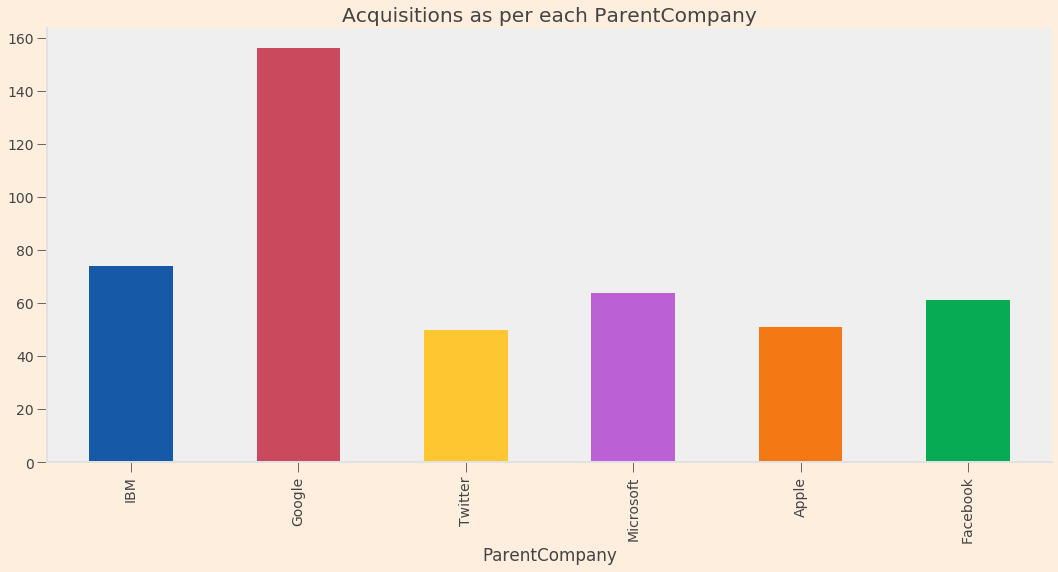

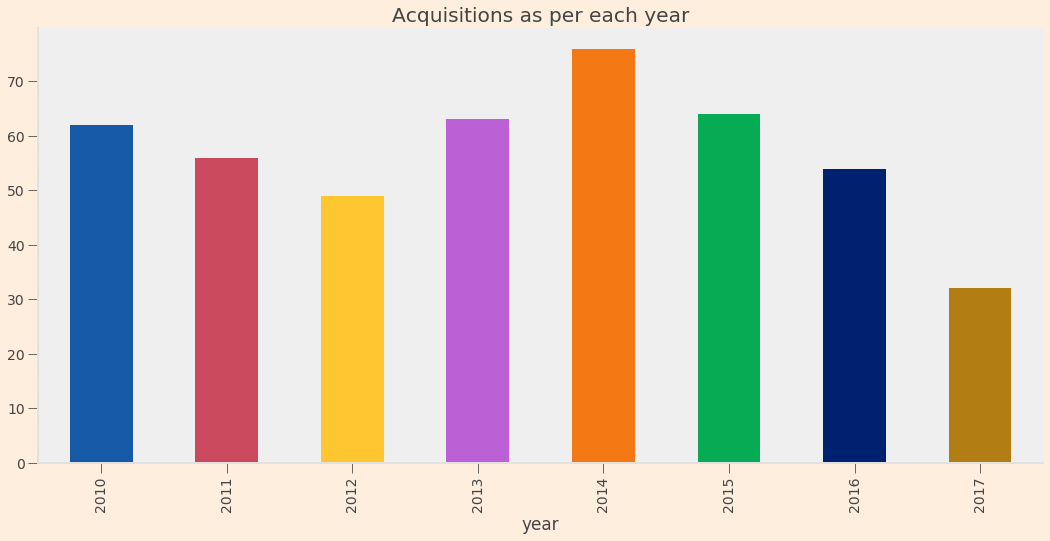

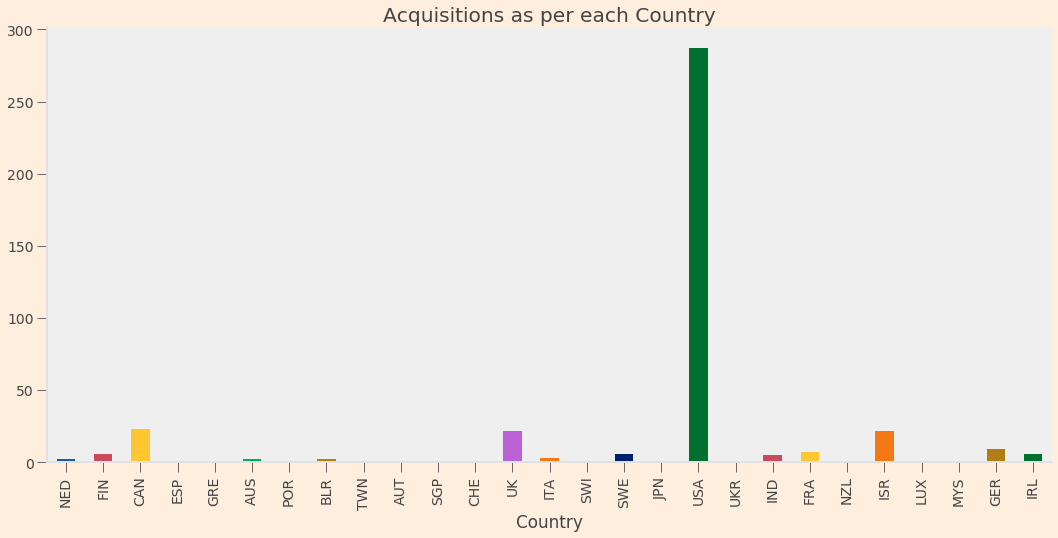

In [66]:
# Total number of acquisitions by each company, year, and country.
background = tuple(np.array([253, 238, 222]) / 255)

for col in ("ParentCompany", "year", "Country"):
    fig, ax = plt.subplots(figsize = (18,8))
    acq[col].value_counts(sort = False).plot(kind = "bar" , color = colors, grid = False) 
    plt.xlabel(str(col))
    plt.title("Acquisitions as per each {}".format(col))       
    fig.set_facecolor(background)

As we can see, Google leads the number of acquisitions. Meanwhile, there have been quite a lot of acquisitions in the last ten years. Finally, most companies acquired by these technology companies were US-based.

As previously mentioned, Google, is the company with highest number of acquisition in the last 10 years. We will further try to visualize Google's acquisition. More specifically, the next graph will try to visualize the Google's number of acquisitions for each year and the value of each acquisition.

In [67]:
# We generate an interactive graph to understand a little more Google's acquisitions (year, amount and value)
def generate_graph(df, name, color):
    t = df[['Company Acquired', 'year']].groupby('year').agg({'Company Acquired' : lambda x : "|".join(x)})
    x = []
    y = []
    z = []
    s = []
    for i, each in enumerate(t.index):
        x1 = each
        y1 = t.values[i][0].split("|")
        for j,comp in enumerate(y1):
            x.append(x1)
            y.append(j+3)
            p = df[df['Company Acquired'] == comp]['Value (USD)'].iloc(0)[0]
            if str(p).lower() == "nan":
                z.append("Company Acquired: " + comp)
            else:
                z.append("Company Acquired: " + comp +" <br> Amount: $"+ str(int(p)))
            if p > 1000000000:
                s.append(23)
            elif p > 50000000:
                s.append(21)
            elif p > 25000000:
                s.append(19)
            elif p > 12500000:
                s.append(17)
            elif p > 6500000:
                s.append(15)
            elif p > 25000:
                s.append(13)
            else:
                s.append(10)

    trace1 = go.Scatter(x=x, y=y, mode='markers', text=z, marker=dict(size=s, color=color))
    data = [trace1]
    layout = go.Layout(title="All acquisitions By " + name,  yaxis=dict(
            autorange=True,
            showgrid=False,
            zeroline=False,
            showline=False,
            ticks='',
            showticklabels=False
        ), height=600)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

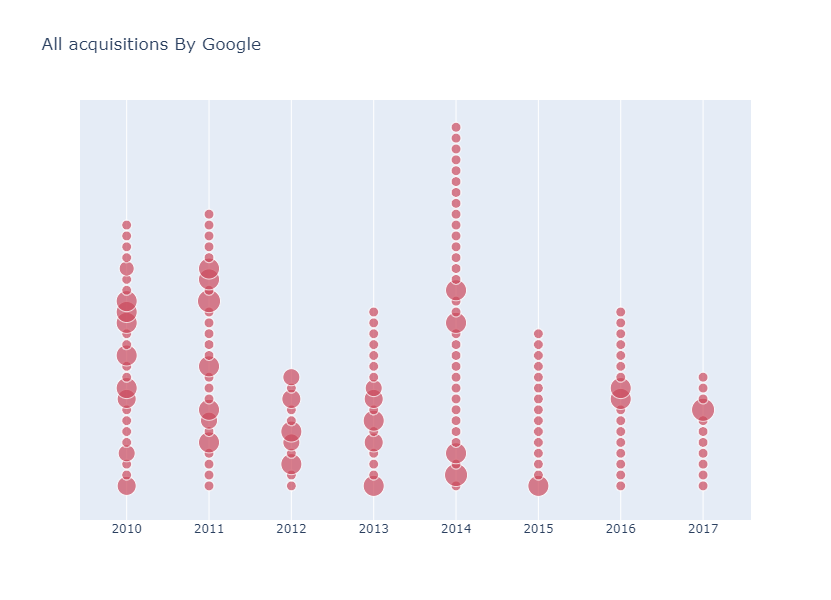

In [68]:
color = colors[1]
name = "Google"
df = acq[acq['ParentCompany'] == name] 
generate_graph(df, name , color)

Google have had some large acquisitions in the last years. To mention some, we have Global IP Solutions, Motorola, Nest Labs, Deep Ming Technologies, Orbitera, and many others. It is easy to indentify them with the above interactive graph.

## Stock Prices


First, we will perform some cleaning and explotory analysis.

In [69]:
print(data.info())
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11459 entries, 0 to 11458
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gvkey         11459 non-null  int64  
 1   iid           11459 non-null  int64  
 2   datadate      11459 non-null  object 
 3   tic           11459 non-null  object 
 4   capgn         0 non-null      float64
 5   cheqv         1 non-null      float64
 6   divd          86 non-null     float64
 7   divsp         0 non-null      float64
 8   capgnpaydate  0 non-null      float64
 9   cheqvpaydate  1 non-null      object 
 10  divdpaydate   86 non-null     object 
 11  cshoc         11454 non-null  float64
 12  eps           10785 non-null  float64
 13  prccd         11459 non-null  float64
 14  prchd         11459 non-null  float64
 15  prcld         11459 non-null  float64
 16  prcod         11459 non-null  float64
dtypes: float64(11), int64(2), object(4)
memory usage: 1.5+ MB
None
gvkey 

In [70]:
# Erase columns with plenty of missing values
data = data.drop(columns={"capgn", "eps", "cshoc", "cheqv", "divd", "divsp", "capgnpaydate", "cheqvpaydate", "divdpaydate"})

#change datadate from object to datetime.
data['datadate'] =pd.to_datetime(data['datadate'])

#Change date range, from 2014 to 2018, to concentrate on the last years.
data = data[(data['datadate'] >= "2014-07") & (data["datadate"] < "2018")]


We will want to analyze the daily percentage change in stock price for each company.

In [71]:
# Create new function
def daily_change(data):
    data["daily_percentage_change"] = (data["prccd"] - data["prcod"]) / data["prcod"] * 100
    stock_daily_change = data[["datadate","daily_percentage_change"]].copy()
    stock_daily_change.sort_values(by =["datadate"], inplace=True)
    return stock_daily_change

#Apply function and merge.
stock_daily_change = data.groupby(by="tic").apply(daily_change)
stock_daily_change.reset_index()
data1 = pd.merge(data, stock_daily_change, on = ["tic", "datadate"], how = "left")

#Customize the merged stock dataset.
data1 = data1.drop(columns = {"iid"}) 
data1= data1.rename(columns = {"daily_percentage_change": "Daily_Percentage_Change", "prccd" : "Close", "prchd": "High", "prcld": "Low", "prcod":"Open", "tic" : "ticker"})


For the  first visualization of this section, I want to analyze the evolution of stock prices changes for selected companies.

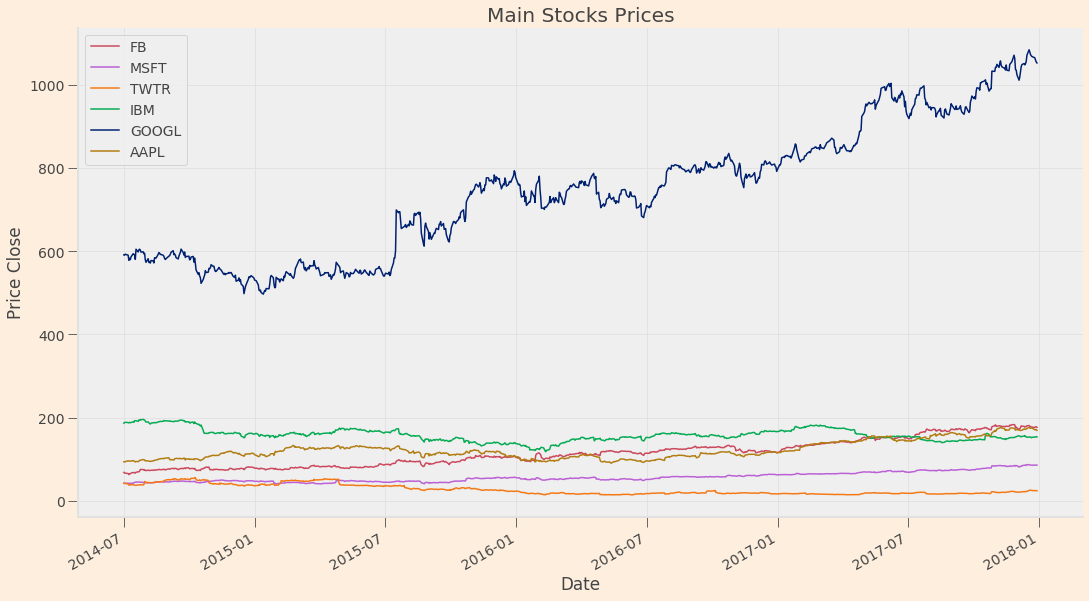

In [72]:
# We create subsets of our depending on the stock ticker.
data_google = data1[data1['ticker'] == "GOOGL"]
data_apple = data1[data1["ticker"] == "AAPL"]
data_fb = data1[data1['ticker'] == "FB"]
data_microsoft = data1[data1["ticker"] == "MSFT"]
data_ibm = data1[data1["ticker"] == "IBM"]
data_twitter = data1[data1["ticker"] == "TWTR"]

#We plot all the lines in one graph.
background = tuple(np.array([253, 238, 222]) / 255)
fig, ax = plt.subplots(figsize = (18, 10))

data_fb.plot( x = "datadate", y = "Close" , label = "FB", ax = ax, color = colors[1])
data_microsoft.plot( x = "datadate", y = "Close"  , label = "MSFT", ax = ax, color = colors[3])
data_twitter.plot( x = "datadate", y ="Close"  , label = "TWTR", ax = ax , color = colors[4]) 
data_ibm.plot( x = "datadate", y = "Close" , label = "IBM", ax = ax , color = colors[5])
data_google.plot( x = "datadate", y = "Close" , label = "GOOGL", ax = ax , color = colors[6])
data_apple.plot( x = "datadate", y = "Close" , label = "AAPL", ax = ax , color = colors[7])

plt.xlabel("Date")
plt.ylabel("Price Close")
plt.title("Main Stocks Prices")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.set_facecolor(background)

Google have had a growing stock price over the last 5 years. Moreover, as we saw in the acquisition dataset, this company had the largest number of acquisitions in the last years.

Now, I will present a new visualization, this time looking at our new variable created (daily percentage change).

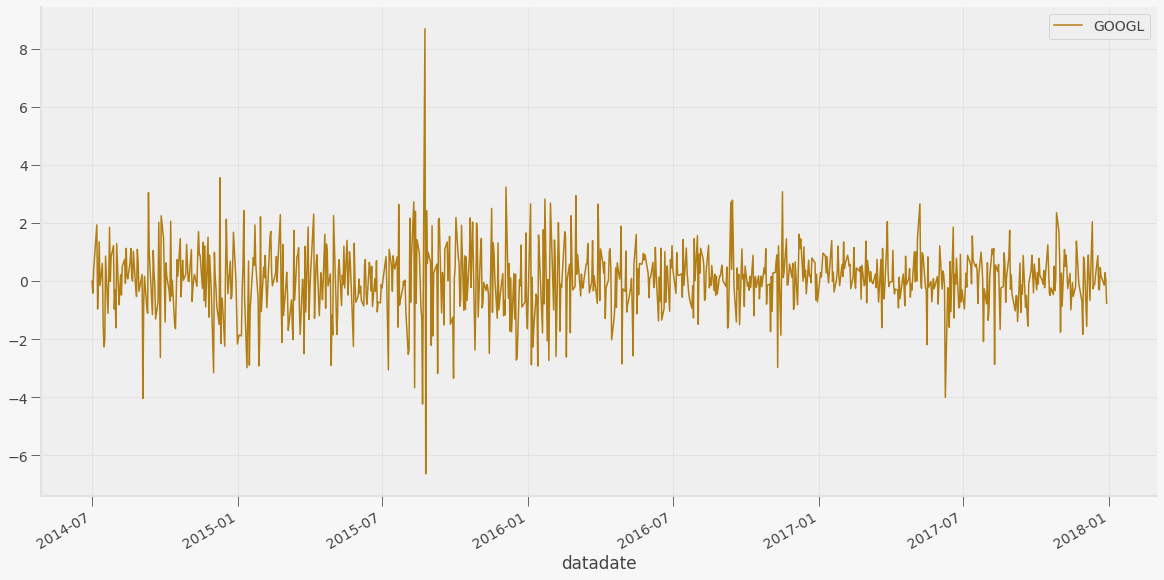

In [73]:
bgcolor = (250/255, 250/255, 250/255)

fig, ax = plt.subplots(figsize = (20,10))

data_google.plot( x = "datadate", y = "Daily_Percentage_Change", label = "GOOGL", ax= ax, color = colors[7])



It's movement looks consistent. Nevertheless, there were a couple of abrupt movements during 2015 and 2016, this is good for future prediction since it didn't have much volatile movement.

Now, I will merge the two datasets. The date range from the acquisition dataset must match the date range of the stocks dataset.
Moreover, we will drop some variables that we will not further consider


In [74]:
# Choose more concentratad data range for acquisition so it muches with the stock data.
acq = acq[(acq["datadate"] >= "2014-07") & (acq['datadate'] < "2018")]
# Create Acquisition column showing Yes for each acquisition.
acq["Acquisition"] = "Yes"

# We will need to drop value, since there many missing values, this could hurt the merged dataset and the future prediction.
acq = acq.drop(columns = {"ParentCompany", "Value (USD)", "year"})

In [75]:
acq_google = acq[acq['TICKER'] == "GOOGL"]
acq_apple = acq[acq["TICKER"] == "AAPL"]
acq_fb = acq[acq['TICKER'] == "FB"]
acq_microsoft = acq[acq["TICKER"] == "MSFT"]
acq_ibm = acq[acq["TICKER"] == 'IBM']
acq_twitter = acq[acq["TICKER"] == "TWTR"]

# First merge independently, then append the datasets.
goog_merged = pd.merge(data_google, acq_google, on = "datadate", how = "left")
fb_merged = pd.merge(data_fb, acq_fb, on ="datadate", how = "left")
msft_merged = pd.merge(data_microsoft, acq_microsoft, on = "datadate", how = "left")
ibm_merged = pd.merge(data_ibm, acq_ibm, on ="datadate", how = "left")
twtr_merged = pd.merge(data_twitter, acq_twitter, on = "datadate", how = "left")
apple_merged = pd.merge(data_apple, acq_apple, on = "datadate", how = "left")

data_merged = goog_merged.append([fb_merged, msft_merged, ibm_merged, twtr_merged, apple_merged])

# We clean our new dataframe and drop some unneccessary columns. 
data_merged["Acquisition"] = data_merged["Acquisition"].replace(np.nan, "No", regex = True)
data_merged["Company Acquired"]= data_merged["Company Acquired"].replace(np.nan, "None", regex = True)
data_merged["Country"] = data_merged["Country"].replace(np.nan, "None", regex = True)
#Unfortunately, we will need to drop value (USD) of acquisition since there is not enough info.
data_merged.head(3)


,gvkey,datadate,ticker,Close,High,Low,Open,Daily_Percentage_Change,TICKER,Company Acquired,Country,Acquisition
0,160329,2014-07-01,GOOGL,591.49,593.66,586.29,587.65,0.000000,GOOGL,Songza,USA,Yes
1,160329,2014-07-02,GOOGL,590.78,594.15,589.11,592.26,-0.410164,NaN,None,None,No
2,160329,2014-07-03,GOOGL,593.08,594.25,589.00,591.70,0.384328,NaN,None,None,No


Now that we have our data merged, I will provide a visualization where I will analyze the relationship between acquisition data and stock price movement over the dat range selected.

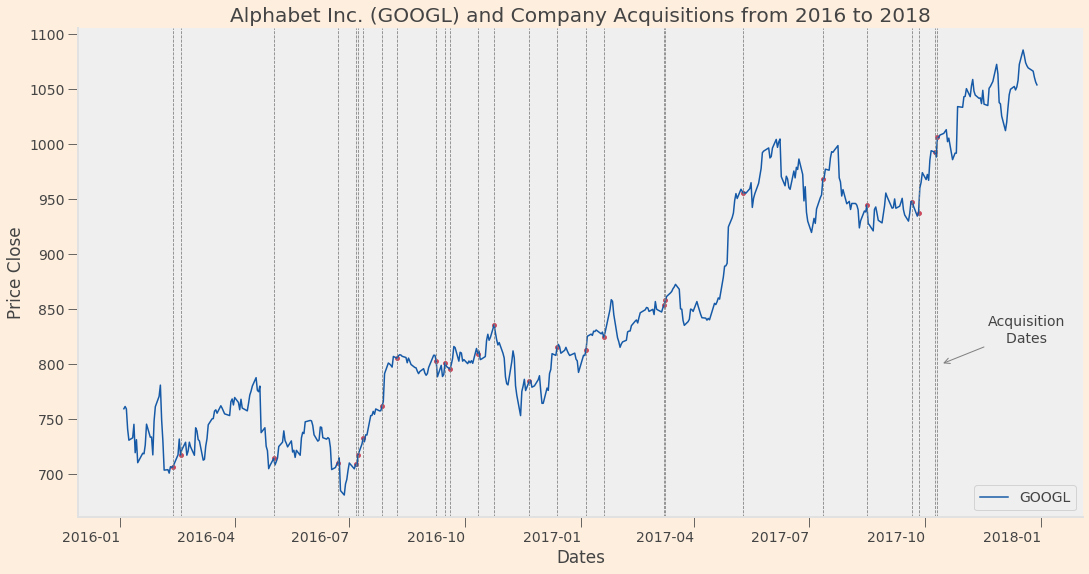

In [76]:
# Change data range for a better visualization
data_google1 = data_merged[(data_merged['ticker'] == "GOOGL")]
data_google1 = data_google1[(data_google1["datadate"] > "2016-01")]
# Create a variable with only acquisition dates
acqs = data_google1[(data_google1["Acquisition"] == "Yes") ]

# plot google stock data.
background = tuple(np.array([253, 238, 222]) / 255)
fig, ax = plt.subplots(figsize = (18, 10))

data_google1.plot( x = "datadate", y = "Close" , label = "GOOGL", ax = ax , color = colors[0])
acqs.plot( kind = "scatter", marker = ".", s = 60, x= "datadate", y = "Close" , ax = ax, color =  colors[1], grid = False)

plt.xlabel("Dates")
plt.ylabel("Price Close")
plt.title("Alphabet Inc. (GOOGL) and Company Acquisitions from 2016 to 2018")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.set_facecolor(background)

# Plot gray lines  for each acquisition over those years to compare to the stock price data.
for i in acqs.datadate.values:
    ax.axvline(x = i , color = 'gray', linestyle = "--", linewidth= 0.8)

ax.annotate(s = "Acquisition" + "\n" + "    Dates", xy = ("2017-10-14", 800), xytext=["2017-11-20", 820],
            arrowprops = dict(arrowstyle = '->',color = "gray", lw = 1 ))
plt.show()

Visually, we can see that stock prices reacted mostly positively with each acquisition (represented by the gray lines). Now that we saw some relationship between the stocks and acquisitions dataset, we will start the prediction model taking into account the findings showed before.

## Prediction models

As we have seen throughout the notebook, Alphabet Inc (or GOOGL as we have seen it) have showed more than interesting results in the acquisition and stock data exploratory analysis and visualizations. For the prediction model this time I will utilize Alphabet Inc merged data to create a prediction model based on the stock and acquisition data in our Dataframe.

First, we will change the acquisition, an independent variable, to a categorical value. Since this is an important variable that we have seen throughout the project, we will include it in our model as a dummy variable ( 0 = No Acquisition, 1 = Yes )


In [77]:
data_merged['Acquisition'] = data_merged['Acquisition'].astype('category')
data_merged["Country"] = data_merged["Country"].astype("category")
data_merged['Acquisition'] = data_merged['Acquisition'].cat.codes
data_merged['Country'] = data_merged['Country'].cat.codes

We will use Alphabet Inc. this time, since it is the company that we have been focusing on. Of course, we can always use other companies for prediction, but we will stick to google this time since this is the company we have been focusing on.

In [78]:
google = data_merged[data_merged["ticker"] == "GOOGL"]

First, I will present a visualization of the relationship between the daily percentage change of the stock price and the acquisition dummy variables we previously computed.

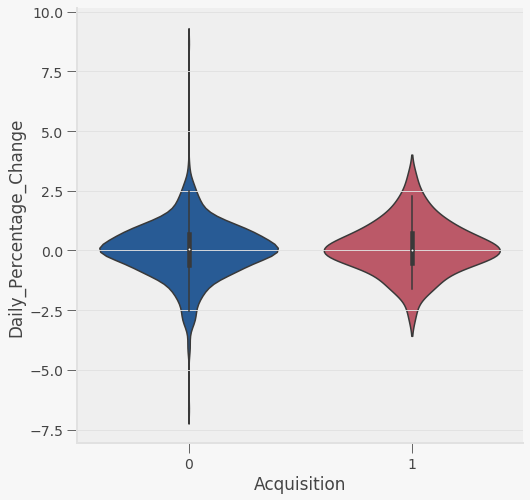

In [79]:
fig1, ax = plt.subplots(figsize = (8, 8))
violin = sns.violinplot(x=google["Acquisition"], y=google["Daily_Percentage_Change"], data=google)

The violin plot provides interesting results for Acquisition = 1. The shape of the graph says that it is relatively normally distributed compared to No Acquisition. It has less extreme values, and it is slightly moving towards positive percentage change. Since it shows some interesting results, we will use the dummy variable on the prediction variables.


I will divide our data in subsets : train and validation poritons and use a 0.75 cutoff for the train model, the rest of the data will be usedd for validation sets. Later, I will include Open, High, Low, daily change and Acquisition in the subset matrix.

In [114]:
# Divide train and validation sets from GOOGL data.
train = google[0:664]
valid = google[664:]

# 3 correspond to Close Price, while 4,5,6,7 and 11 correspond to High, Low, Open and Acquisition.
x_train = train.iloc[:,[4,5,6,7,11]]
y_train = train.iloc[:,3]
date_train=train.iloc[:,1]
x_valid = valid.iloc[:,[4,5,6,7,11]]
y_valid = valid.iloc[:,3]
date_valid=valid.iloc[:,1]

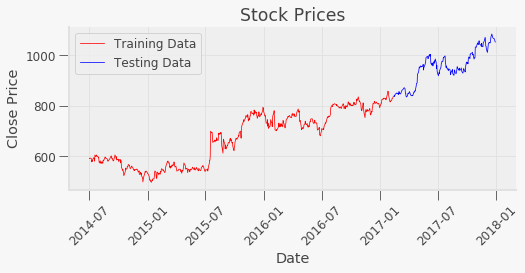

In [115]:
# Provide a preview of the train and valid sets plotted against the dates
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize = (8,3))
ax.plot(date_train, y_train, color = 'red', marker='', linewidth='0.75')
ax.plot(date_valid, y_valid, color = 'blue', marker='', linewidth='0.75')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.legend(['Training Data', 'Testing Data'], loc='upper left')
ax.set(xlabel="Date",
       ylabel="Close Price",
       title="Stock Prices");
plt.show()

For prediction, I will choose between four common types depending on their results : Linear Regression, Lasso Regression, Random Forest and Ridge Regression. 

In [116]:
import warnings
warnings.filterwarnings("ignore")

# Simple linear regression
lr= linear_model.LinearRegression()
lr.fit(x_train, y_train)

train["close_pred_lr"] = lr.predict(x_train)
valid["close_pred_lr"] = lr.predict(x_valid)

# Lasso regression with alpha = 0.5
lasso = Lasso(alpha=0.5)
lasso.fit(x_train,y_train)

train["close_pred_ls"] = lasso.predict(x_train)
valid["close_pred_ls"]= lasso.predict(x_valid)

# Random forest with 5 decision trees and 42 random states.
rf = RandomForestRegressor(n_estimators = 50, random_state = 42)
rf.fit(x_train,y_train)

train["close_pred_rf"] = rf.predict(x_train)
valid["close_pred_rf"] = rf.predict(x_valid)

#Ridge regression with alpha = 0.5
ridge = Ridge(alpha = 0.5)
ridge.fit(x_train,y_train)

train["close_pred_rdg"] = ridge.predict(x_train)
valid["close_pred_rdg"] = ridge.predict(x_valid)


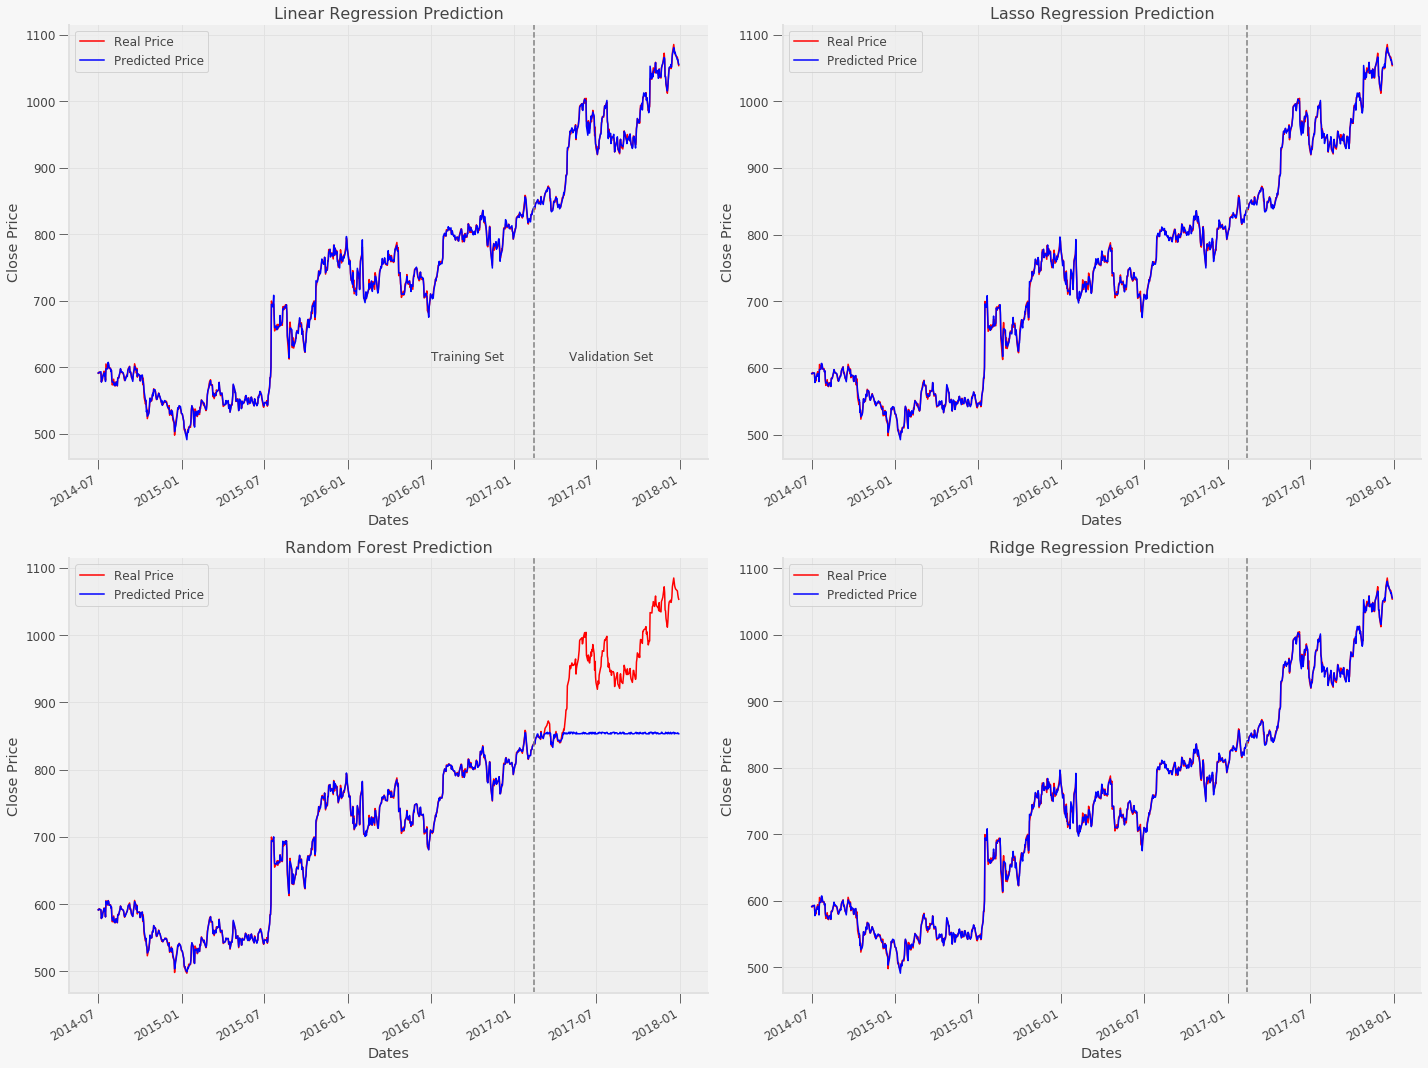

In [117]:
colors = ['red', 'blue']
fig, axs = plt.subplots(2 ,2 ,figsize=(20, 15))

train.plot(y = "Close", x = "datadate", c = colors[0], ax = axs[0,0])
valid.plot(y = "Close", x = "datadate", c = colors[0], ax= axs[0,0])
train.plot(y = "close_pred_lr", x = "datadate" , c = colors[1], ax = axs[0,0])
valid.plot(y = "close_pred_lr", x = "datadate", c = colors[1], ax = axs[0,0])

train.plot(y = "Close", x = "datadate", c = colors[0], ax = axs[0,1])
valid.plot(y = "Close", x = "datadate", c = colors[0], ax= axs[0,1] )
train.plot(y = "close_pred_ls", x = "datadate" , c = colors[1], ax = axs[0,1])
valid.plot(y = "close_pred_ls", x = "datadate", c = colors[1], ax = axs[0,1])

train.plot(y = "Close", x = "datadate", c = colors[0], ax = axs[1,0])
valid.plot(y = "Close", x = "datadate", c = colors[0], ax= axs[1,0] )
train.plot(y = "close_pred_rf", x = "datadate" , c = colors[1], ax = axs[1,0])
valid.plot(y = "close_pred_rf", x = "datadate", c = colors[1], ax = axs[1,0])

train.plot(y = "Close", x = "datadate", c = colors[0], ax = axs[1,1])
valid.plot(y = "Close", x = "datadate", c = colors[0], ax= axs[1,1] )
train.plot(y = "close_pred_rdg", x = "datadate" , c = colors[1], ax = axs[1,1])
valid.plot(y = "close_pred_rdg", x = "datadate", c = colors[1], ax = axs[1,1] )

for ax in axs.flat:
    ax.set_xlabel('Dates')
    ax.set_ylabel('Close Price')
    ax.axvline(x = "2017-02-13", color = 'gray', linestyle = "--")
    ax.legend(['Real Price', 'Predicted Price']) 
    leg = ax.get_legend()
    leg.legendHandles[0].set_color(colors[0])
    leg.legendHandles[1].set_color(colors[1])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
axs[0,0].set_title('Linear Regression Prediction', size=16)
axs[0,1].set_title('Lasso Regression Prediction', size=16)
axs[1,0].set_title('Random Forest Prediction', size=16)
axs[1,1].set_title('Ridge Regression Prediction', size=16)

axs[0,0].annotate('Training Set', xy = ("2016-07-01", 610))
axs[0,0].annotate('Validation Set', xy = ("2017-05-01", 610))

fig.tight_layout()

Visually, Linear Regression, Lasso and Ridge Regression provided really accurate predictions for train and validation sets. Random forest's prediction was not accurate, probably because they don’t fit very well for increasing or decreasing trends which are usually encountered when dealing with time-series analysis.One way to improve the Random forest would be to drop the time-series variables from our model, but the current dataset only has these kind of variables, so we will drop this model for this time.

The visualization of the three accurate models will be further analyzed through more exact metrics to see which one predicts better.

In [118]:
from sklearn import metrics

def report_metrics(mod, x_train, x_valid, y_train, y_valid):
    mod.fit(x_train, y_train)
    return dict(
        mae_train=metrics.mean_absolute_error(y_train, mod.predict(x_train)),
        mae_valid=metrics.mean_absolute_error(y_valid, mod.predict(x_valid)),
        rmse_train=metrics.mean_squared_error(y_train, mod.predict(x_train), squared = False),
        rmse_valid=metrics.mean_squared_error(y_valid, mod.predict(x_valid), squared= False),
        r2_train=metrics.r2_score(y_train, mod.predict(x_train)),
        r2_valid=metrics.r2_score(y_valid, mod.predict(x_valid))
    )

lr_metric = report_metrics(lr, x_train, x_valid, y_train, y_valid)
ls_metric = report_metrics(lasso, x_train, x_valid, y_train, y_valid)
rf_metric = report_metrics(rf, x_train, x_valid, y_train, y_valid)
ridge_metric = report_metrics(ridge, x_train, x_valid, y_train, y_valid)

metrics = pd.DataFrame(dict(linreg = lr_metric, lasso =  ls_metric, rf = rf_metric, rdge = ridge_metric))
metrics

,linreg,lasso,rf,rdge
mae_train,2.322442,2.370285,1.160872,2.322498
mae_valid,2.529607,2.485438,101.674580,2.529548
rmse_train,3.112688,3.156373,1.617240,3.112688
rmse_valid,3.518383,3.486794,120.714061,3.518293
r2_train,0.999114,0.999089,0.999761,0.999114
r2_valid,0.997289,0.997338,-2.190787,0.997290


As we can see, Lasso appearently shows lower Mean Absolute Error and Root Mean Square for the validation sets, as well as higher R2 squared. So we will choose Lasso for our best prediction model

Now that we have chosen a machine learning prediction model, let's try to further improve its accuracy with better regularization parameters. For Lasso, the most obvious regularization instrument would be cross validation regularization. We will choose a default cross validation fold of 5, and apply its results to a new improved lasso regression model.

In [119]:
from sklearn import metrics
# Use cross validation to get the minimizer alpha 
lassoCV = linear_model.LassoCV(cv=5).fit(x_train,y_train)
lasso_improved = Lasso(alpha = np.log10(lassoCV.alpha_))
lasso_improved.fit(x_train, y_train)

Lasso(alpha=1.0406190357548812, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Before we numerically analyze the scores, let's try to infere the difference with an error visualization. 

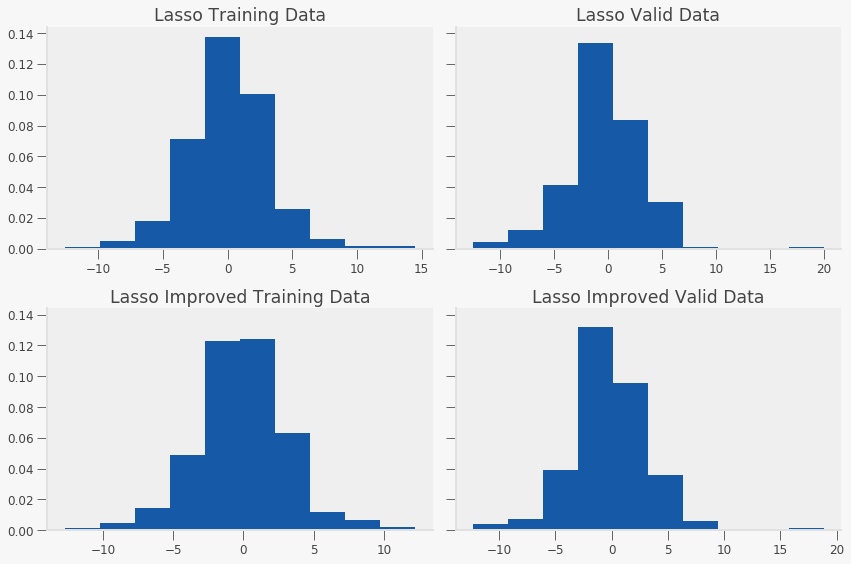

In [120]:
y_train_lasso = lasso.predict(x_train)
y_valid_lasso = lasso.predict(x_valid)
y_train_impro = lasso_improved.predict(x_train)
y_valid_impro = lasso_improved.predict(x_valid)

fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharey="all")

ax[0,0].hist(y_train_lasso - y_train, density=True)
ax[0,0].set_title("Lasso Training Data")
ax[0,1].hist(y_valid_lasso - y_valid, density=True)
ax[0,1].set_title("Lasso Valid Data")
ax[1,0].hist(y_train_impro - y_train, density = True)
ax[1,0].set_title("Lasso Improved Training Data")
ax[1,1].hist(y_valid_impro - y_valid, density = True)
ax[1,1].set_title("Lasso Improved Valid Data")

for ax in ax.flat:
    ax.grid(False)

fig.tight_layout()



As we can see, the prediction errors of the Improved Lasso model seems to be a little better distributed. Let's check what the metrics show.

In [121]:
# Compare new metrics with previous lasso prediction.
lasso_improved_metrics = report_metrics(lasso_improved , x_train, x_valid, y_train, y_valid)
metrics_v2 = pd.DataFrame(dict(lasso =  ls_metric, lasso_improved = lasso_improved_metrics))
metrics_v2

,lasso,lasso_improved
mae_train,2.370285,2.448617
mae_valid,2.485438,2.498369
rmse_train,3.156373,3.231778
rmse_valid,3.486794,3.443609
r2_train,0.999089,0.999045
r2_valid,0.997338,0.997403


Lasso Improved has a slightly lower Root Mean Square and a higher R2 squared for the validation sets of our data
. This means that the original alpha paramenter was very close to the most accurate one. Even though the prediction accuracy improved only little, regularization techniques have provided us with the (appearently) lowest root mean squared error for our valid tests. Finally, let's see the visualization comparison of Lasso models.

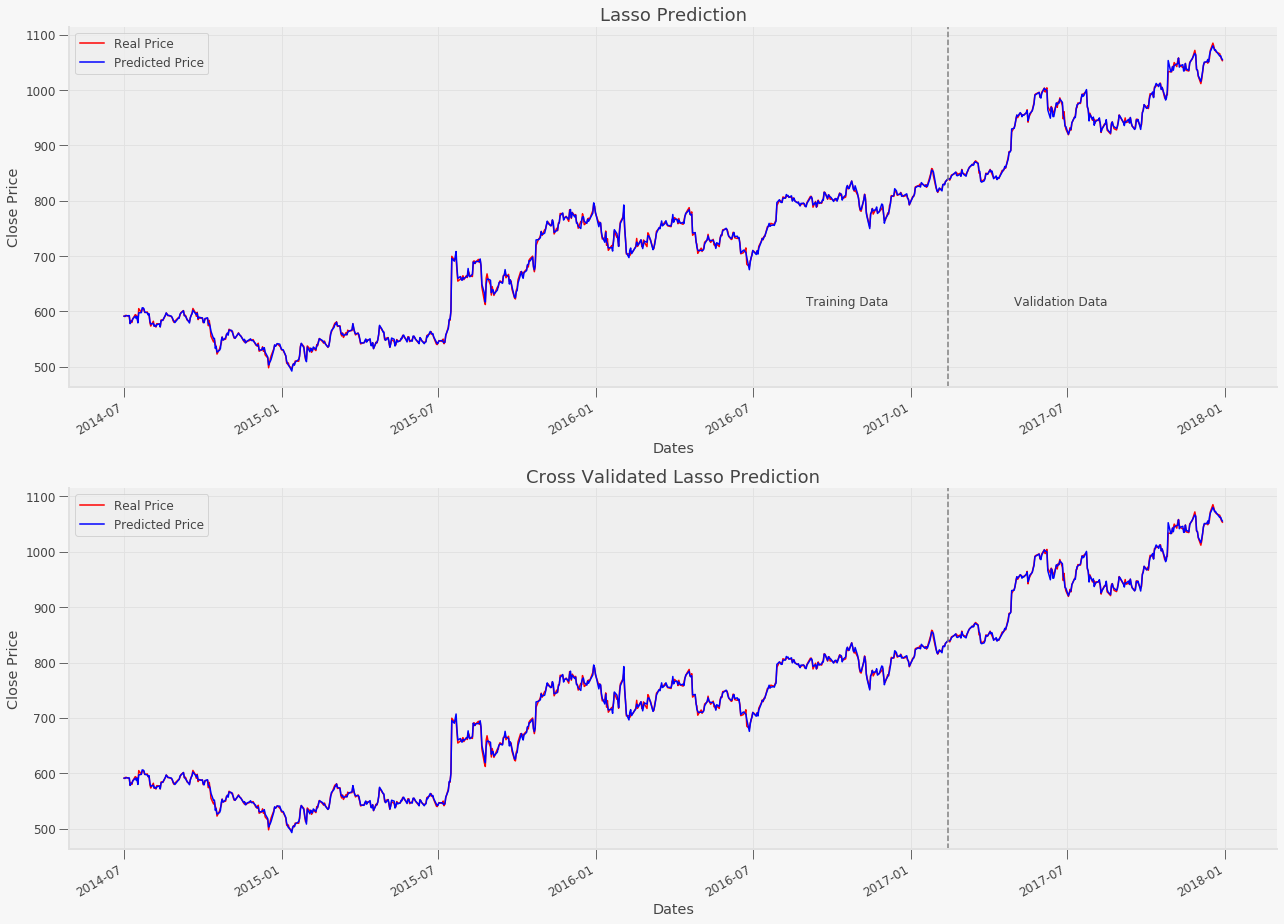

In [122]:
train["close_pred_ls_improved"] = lasso_improved.predict(x_train)
valid["close_pred_ls_improved"] = lasso_improved.predict(x_valid)

colors = ['red', 'blue']
fig, axs = plt.subplots(2, 1, figsize=(18, 13))

train.plot(y = "Close", x = "datadate", c = colors[0], ax = axs[0])
valid.plot(y = "Close", x = "datadate", c = colors[0], ax= axs[0] )
train.plot(y = "close_pred_ls", x = "datadate" , c = colors[1], ax = axs[0])
valid.plot(y = "close_pred_ls", x = "datadate", c = colors[1], ax = axs[0])

train.plot(y = "Close", x = "datadate", c = colors[0], ax = axs[1])
valid.plot(y = "Close", x = "datadate", c = colors[0], ax= axs[1])
train.plot(y = "close_pred_ls_improved", x = "datadate" , c = colors[1], ax = axs[1])
valid.plot(y = "close_pred_ls_improved", x = "datadate", c = colors[1], ax = axs[1])

for ax in axs.flat:
    ax.axvline(x="2017-02-13", color = 'gray', linestyle = "--")
    ax.set_xlabel('Dates')
    ax.set_ylabel('Close Price')
    ax.legend(['Real Price', 'Predicted Price'])
    leg = ax.get_legend()
    leg.legendHandles[0].set_color(colors[0])
    leg.legendHandles[1].set_color(colors[1])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

axs[0].set_title('Lasso Prediction', size= 18)
axs[1].set_title('Cross Validated Lasso Prediction', size = 18)
axs[0].annotate('Training Data', xy = ("2016-09-01", 610))
axs[0].annotate('Validation Data', xy = ("2017-05-01", 610))

fig.tight_layout()

The lower visualization is the graph with the lowest mean squared error when using Lasso regression with cross validation of 5-k fold. Moreover, it has the highest R2 squared. Nevertheless, the scores are almost the same, which shows that the previous selection of alpha was very close to the most accurate. Nevertheless, I still ahve doubts regarding the random forest prediction, I believe future work should include stationary data for the company, which could improve the generalization of the random forest.



## Conclusion

<div style="text-align: justify"> 
I explored the acquisition and stock price datasets separately and provided interesting visualizations. Then, I merged the datasets to look for further information and added extra variables to better understand the data. After that whole process, the datasets and visualizations show interesting results:

</div>

1) There have been many acquisitions during the last years. Also, Us-based companies were the most acquired during that data range. Within the Parent companies, Alphabet Inc. had the highest number of acquisition over the last 10 years

2) Then, the same company had the highest Close stock price over the last years in our dataset.

3) Visually, Google stock reacted mostly positively to each acquisition in the date range chosen.

<div style="text-align: justify"> 
    
Later, I decided to use Alphabet Inc for further research in the prediction portion of the project including the acquisition insights given before.
After choosing between four machine learning methods, I decided to use Lasso Regression since it provided the lowest Root Mean Square and the highest R2 squared score. I confirmed my model decision with plot visualizations of the four models used. 
    
Then, I improve my model using cross validation of the regularization parameter, by testing a cross validation of 5-k fold for the Lasso model previously established. After performing cross validation and choosing the best regularization parameter, my prediction model provided a slightly lower root mean square and slightly higher R2 squared. Finally, I provide two graphs to confirm visually the accuracy of my prediction model. </div>

The machine learning model provided an accurate prediction for Alphabet Inc. Besides this company, future work should be aimed to analyze the other Big Tech companies. Another company that was not included in the Kaggle acquisition dataset was Amazon Inc., and it should provide interesting results as well.